In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Standard
# df = pd.read_csv('../db/out/wta_std.csv')

# mean
# df = pd.read_csv('../db/out/wta_mean.csv')

# pvp
# df = pd.read_csv('../db/out/wta_pvp.csv')

# mean + pvp
df = pd.read_csv('../db/out/wta_mean_pvp.csv')


# df = pd.read_csv('../db/clean_and_no_NaN/match_stats_with_wins.csv')

# df = pd.read_csv('../db/clean_and_no_NaN/wta_matches_clean.csv')

# df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Ustalanie symetrycznosci cech


In [2]:
testp1 = df.filter(regex='_P1_vs$', axis=1)

testp2 = df.filter(regex='_P2_vs$', axis=1)


feats = list(zip(testp1.columns, testp2.columns))


for col_a, col_b in feats:
    df[col_a + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

non_numeric_columns = df.select_dtypes(['object']).columns

df = df.drop(non_numeric_columns, axis=1)

testp1 = df.filter(regex='_P1$', axis=1)

testp2 = df.filter(regex='_P2$', axis=1)

feats = list(zip(testp1.columns, testp2.columns))

for col_a, col_b in feats:
    df[col_a + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

# Normalizacja danych


In [3]:
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df = df.drop(['match_id'], axis=1)

# for deccision tree plot
# df = df[['rank_points_P1_diff', 'win_percentage_P1_diff',
#          'surface_wins_P1_diff', 'y']]


# for svm plot
df = df[['surface_wins_P1_diff', 'win_percentage_P1_diff', 'y']]


df = df.fillna(df.median())


def normalize(dff):
    result = dff.copy()
    for feature_name in dff.columns:
        max_value = dff[feature_name].max()
        min_value = dff[feature_name].min()
        result[feature_name] = (
            dff[feature_name] - min_value) / (max_value - min_value)
    return result


df = normalize(df)
# df.info()
df = df.fillna(df.median())

# Przygotowanie danych do modelu


In [4]:
from sklearn.model_selection import train_test_split

Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=18, stratify=Y)

# Logistic Regression


              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      3539
         1.0       0.68      0.68      0.68      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



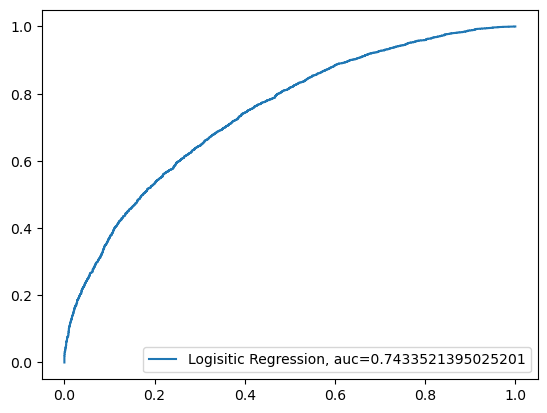

In [5]:
# Logistic regression Basic hiperparameters
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=14, max_iter=1000)

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr_basic, tpr_basic, label="Logisitic Regression, auc="+str(auc_basic))
# plt.legend(loc=4)
# plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.675825289705052
Best Hyperparameters: {'solver': 'sag', 'C': 464.15888336127773}


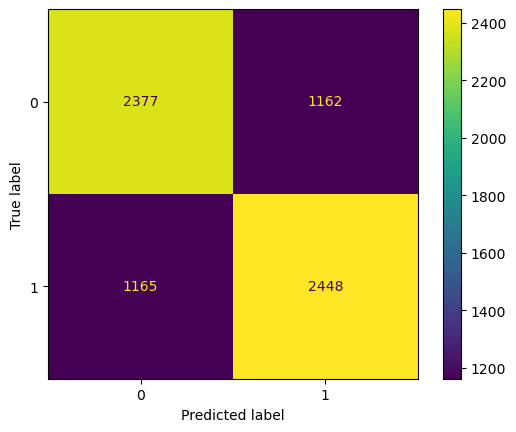

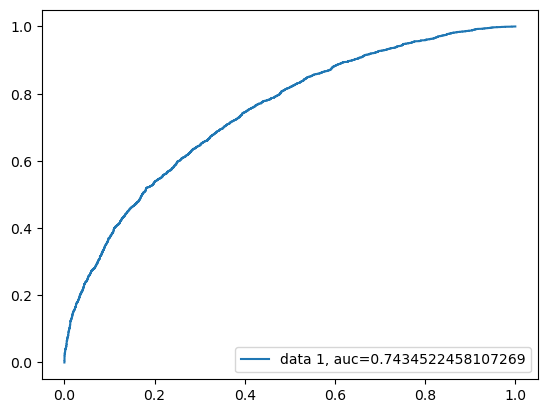

In [6]:
# Logistic regresion with RandomizedSearchCV
model = LogisticRegression()

param_grid = {
    'C': np.logspace(0, 4, num=10),
    'solver': ['liblinear', 'sag', 'newton-cg']
}

search = RandomizedSearchCV(model, param_grid, n_iter=10,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Optimal number of features : 27
                                  Rank
glicko_P1_diff                       1
age_P1_diff                          1
games_played_P1_diff                 1
win_percentage_P1_diff               1
surface_wins_P1_diff                 1
bp_factor_P1_diff                    1
first_won_serve_P1_diff              1
ht_P1_diff                           1
second_won_serve_P1_diff             1
aceDf_P1_diff                        1
points_on_return_P1_diff             1
serve_points_won_P1_diff             1
completeness_P1_diff                 1
total_serve_points_P1_diff           1
ace_probability_P1_diff              1
double_fault_probability_P1_diff     1
df_probability_P1_diff               1
first_serve_return_P1_diff           1
rank_points_P1_diff                  1
ace_probability_P1_VS                1
double_fault_probability_P1_VS       1
elo_P1_diff                          1
win_percentage_P2_VS                 1
aceDf_P1_VS                     

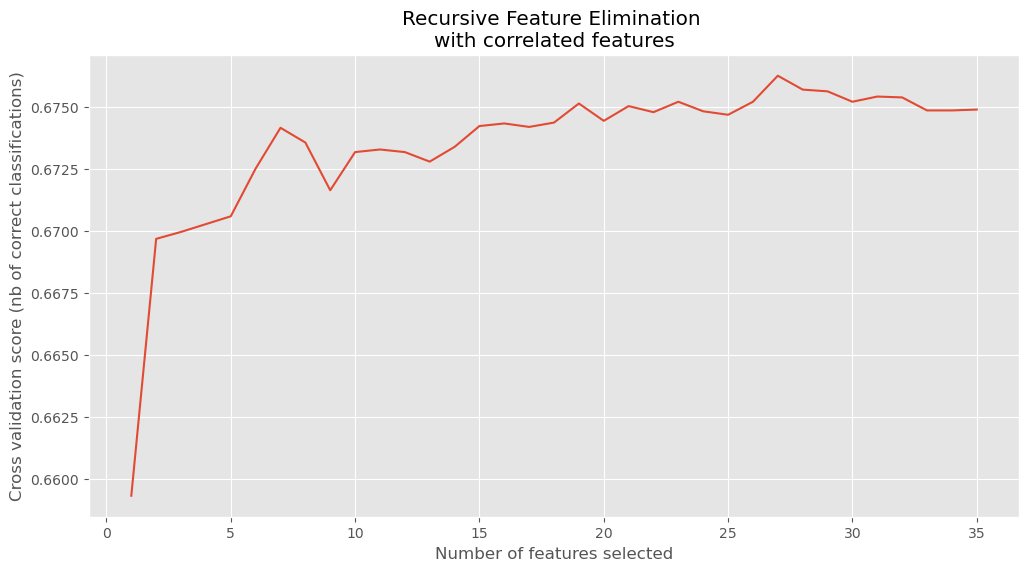

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      3539
         1.0       0.68      0.68      0.68      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



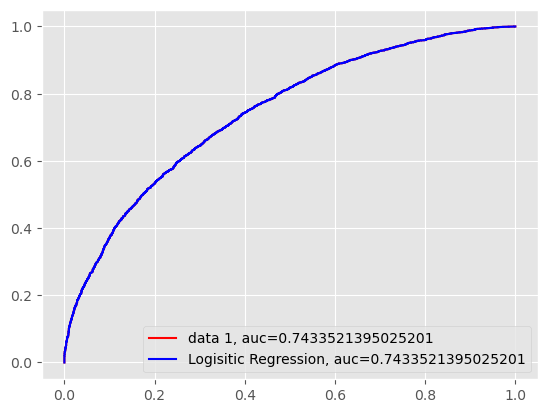

In [6]:
# Logistic regresion with RFECV

from sklearn.inspection import DecisionBoundaryDisplay

model = LogisticRegression(C=464, solver='sag', random_state=14)
cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix


# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.grid(False)
# plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc), color='red')
plt.plot(fpr_basic, tpr_basic, label="Logisitic Regression, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

# Decision Tree


In [5]:
# Decision Tree Basic hiperparameters
from sklearn.tree import DecisionTreeClassifier
from graphviz import Source

model = DecisionTreeClassifier()


result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

y_pred_proba = result.predict(X_test)
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr_basic, tpr_basic, label="Basic, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

              precision    recall  f1-score   support

         0.0       0.58      0.58      0.58      3539
         1.0       0.59      0.58      0.58      3613

    accuracy                           0.58      7152
   macro avg       0.58      0.58      0.58      7152
weighted avg       0.58      0.58      0.58      7152



              precision    recall  f1-score   support

         0.0       0.62      0.71      0.66      3539
         1.0       0.67      0.58      0.62      3613

    accuracy                           0.64      7152
   macro avg       0.64      0.64      0.64      7152
weighted avg       0.64      0.64      0.64      7152



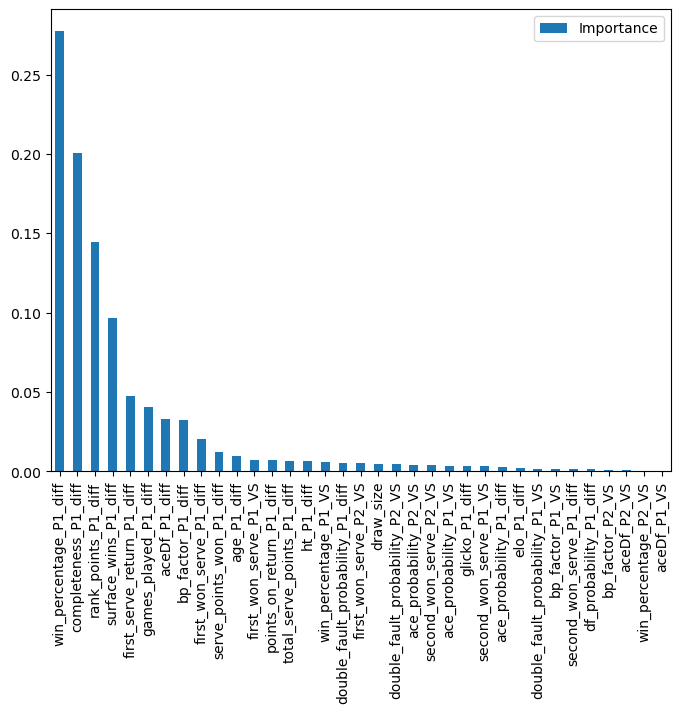

In [6]:
# Decision Tree ferature importance plot


model = DecisionTreeClassifier(
    max_depth=7, max_features='log2', criterion='entropy')


result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


feat_importances = pd.DataFrame(
    model.feature_importances_, index=X_test.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8, 6))
plt.show()

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best Score: 0.6584854799167976
Best Hyperparameters: {'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy'}


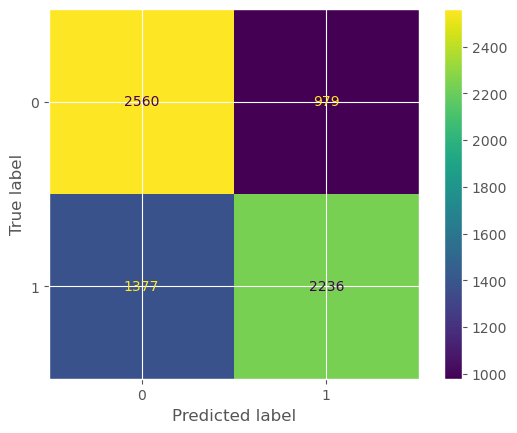

              precision    recall  f1-score   support

         0.0       0.61      0.76      0.68      3539
         1.0       0.69      0.53      0.60      3613

    accuracy                           0.64      7152
   macro avg       0.65      0.64      0.64      7152
weighted avg       0.65      0.64      0.64      7152



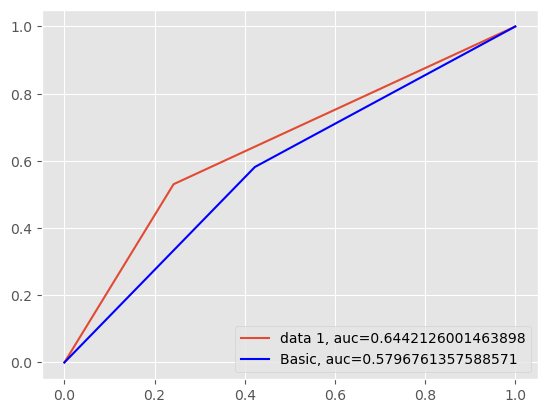

In [16]:
# Decision tree with RandomizedSearchCV

model = DecisionTreeClassifier()


param_grid = {
    'max_depth': list(range(5, 20, 1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

search = RandomizedSearchCV(model, param_grid, n_iter=15,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

# search = RFE(model, n_features_to_select=5, step=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

best_random = result.best_estimator_
y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

Optimal number of features : 3
Index(['rank_points_P1_diff', 'win_percentage_P1_diff',
       'surface_wins_P1_diff'],
      dtype='object')
                        Rank
rank_points_P1_diff        1
win_percentage_P1_diff     1
surface_wins_P1_diff       1
                                  Rank
rank_points_P1_diff                  1
win_percentage_P1_diff               1
surface_wins_P1_diff                 1
first_won_serve_P1_diff              2
games_played_P1_diff                 3
completeness_P1_diff                 4
total_serve_points_P1_diff           5
first_serve_return_P1_diff           6
serve_points_won_P1_diff             7
bp_factor_P1_diff                    8
df_probability_P1_diff               9
double_fault_probability_P2_VS      10
aceDf_P1_diff                       11
first_won_serve_P2_VS               12
ace_probability_P1_diff             13
ace_probability_P1_VS               14
double_fault_probability_P1_VS      15
points_on_return_P1_diff            16
gl

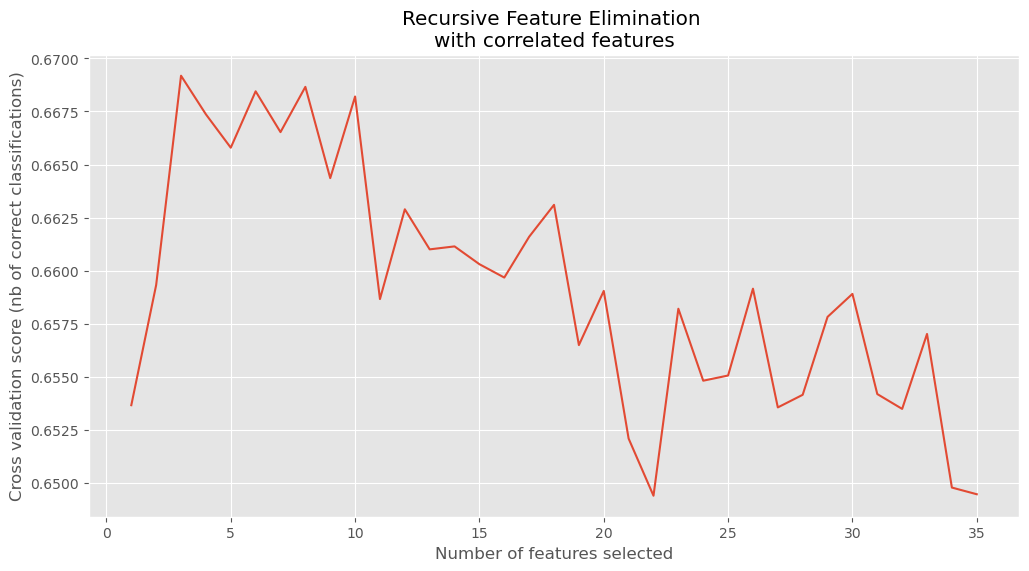

              precision    recall  f1-score   support

         0.0       0.64      0.74      0.69      3539
         1.0       0.70      0.59      0.64      3613

    accuracy                           0.66      7152
   macro avg       0.67      0.66      0.66      7152
weighted avg       0.67      0.66      0.66      7152



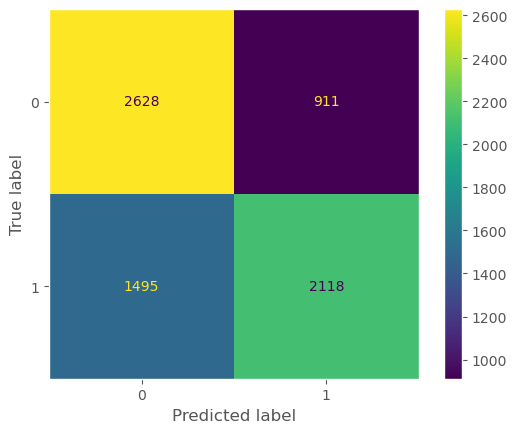

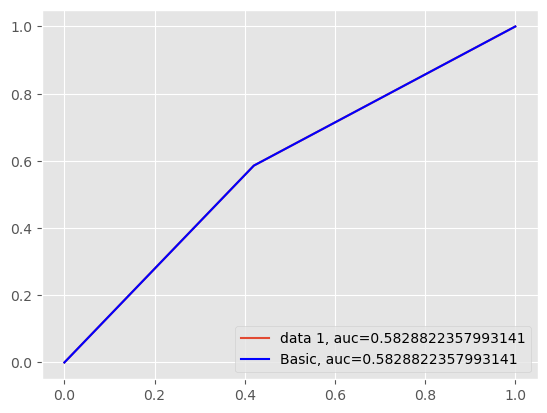

In [39]:
# Decision tree with RFECV
from sklearn.tree import export_graphviz
from graphviz import Source

model = DecisionTreeClassifier(
    max_depth=7, max_features='log2', criterion='entropy')

cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

# print(rfecv.feature_names_in_)

# ranks = pd.DataFrame(
#     rfecv.ranking_, index=X.columns, columns=['Rank'], sorted=True)

# export_graphviz(rfecv.estimator_, out_file='tree.dot', feature_names=ranks[:rfecv.n_features_],
#                 class_names=['0', '1'], rounded=True, filled=True)

Source.from_file('tree.dot')

selected_features = X_train.columns[rfecv.support_]

print(selected_features)


ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

ranks_1 = ranks[ranks['Rank'] == 1]

print(ranks_1)

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

In [6]:
# everyting apllied
from sklearn.tree import export_graphviz
model = DecisionTreeClassifier(
    max_depth=7, max_features='log2', criterion='entropy')


result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


export_graphviz(model, out_file='tree.dot',
                feature_names=X_train.columns, class_names=['0', '1'], rounded=True, filled=True)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68      3539
         1.0       0.69      0.65      0.66      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



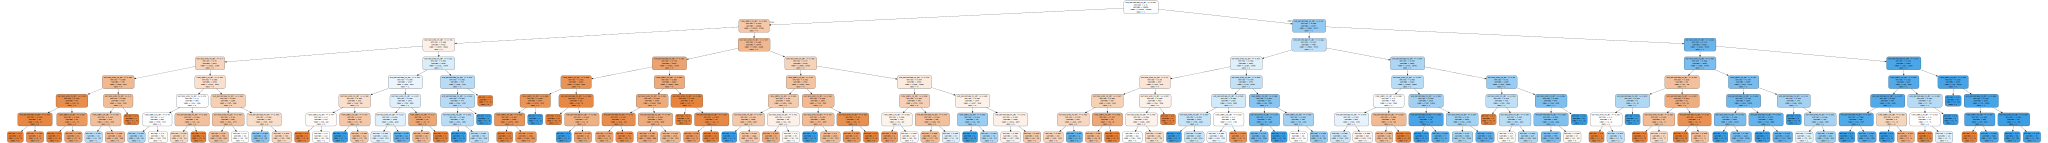

In [7]:
from graphviz import Source
Source.from_file('tree.dot')

# SVM


In [5]:
# Linear SVC Basic hiperparameters
from sklearn import svm

model = svm.LinearSVC()  # Linear Kernel

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


y_pred_proba = result.predict(X_test)
# fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr_basic, tpr_basic, label="Basic, auc="+str(auc), color='red')
# plt.legend(loc=4)
# plt.show()

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.grid(False)
# plt.show()

              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66      3539
         1.0       0.67      0.67      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



Best Score: 0.6759300870398389
Best Hyperparameters: {'loss': 'hinge', 'C': 6}
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      3539
         1.0       0.68      0.66      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



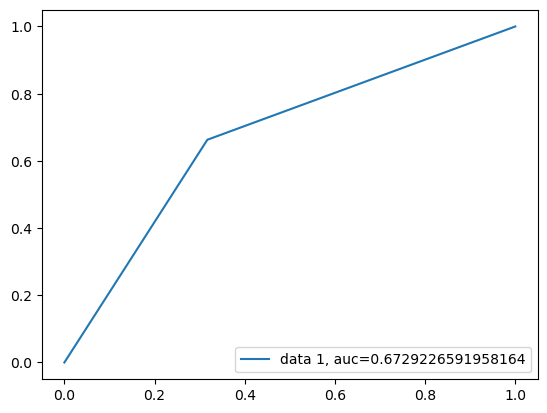

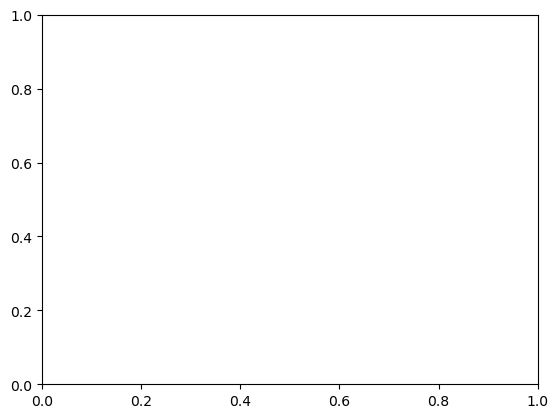

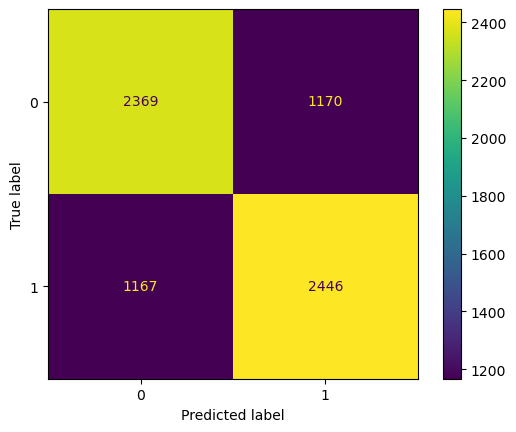

In [11]:
# # Linear SVC with RandomizedSearchCV

# model = svm.LinearSVC()  # Linear Kernel

# param_grid = {'C': range(1, 100, 5),
#               'loss': ['hinge', 'squared_hinge'],
#               }


# search = RandomizedSearchCV(model, param_grid, n_iter=5,
#                             cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# # execute search
# result = search.fit(X_train, y_train)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)


# best_random = result.best_estimator_
# y_pred_test = best_random.predict(X_test)
# print(classification_report(y_test, y_pred_test))

# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
# auc = metrics.roc_auc_score(y_test, y_pred_test)
# plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# plt.grid(False)
# disp.plot()
# plt.show()

Optimal number of features : 32
                                  Rank
glicko_P1_diff                       1
age_P1_diff                          1
games_played_P1_diff                 1
win_percentage_P1_diff               1
surface_wins_P1_diff                 1
bp_factor_P1_diff                    1
first_won_serve_P1_diff              1
ht_P1_diff                           1
second_won_serve_P1_diff             1
aceDf_P1_diff                        1
points_on_return_P1_diff             1
serve_points_won_P1_diff             1
completeness_P1_diff                 1
total_serve_points_P1_diff           1
ace_probability_P1_diff              1
double_fault_probability_P1_diff     1
df_probability_P1_diff               1
first_serve_return_P1_diff           1
rank_points_P1_diff                  1
win_percentage_P1_VS                 1
bp_factor_P1_VS                      1
second_won_serve_P1_VS               1
ace_probability_P1_VS                1
double_fault_probability_P1_VS  

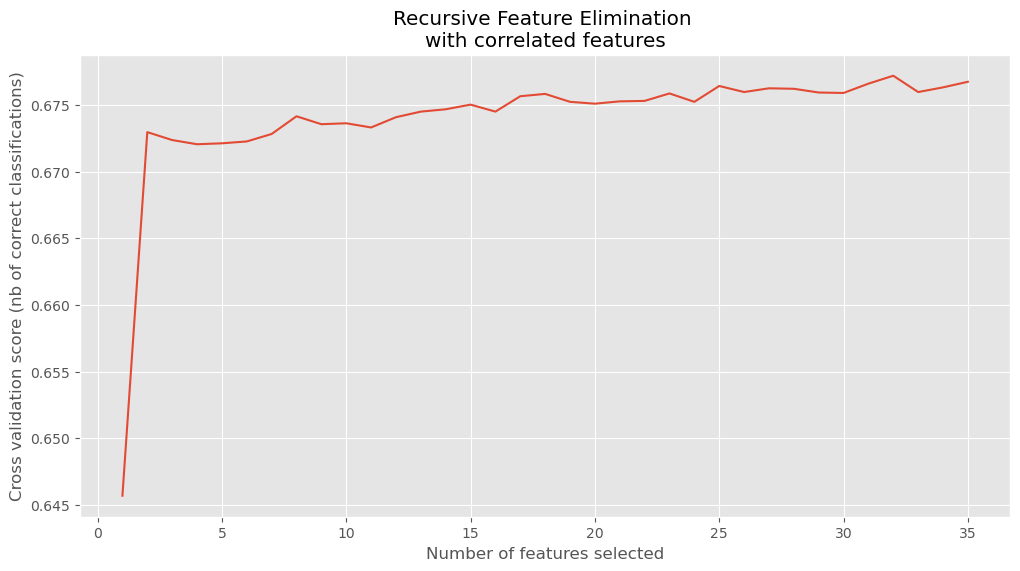

              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      3539
         1.0       0.68      0.66      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



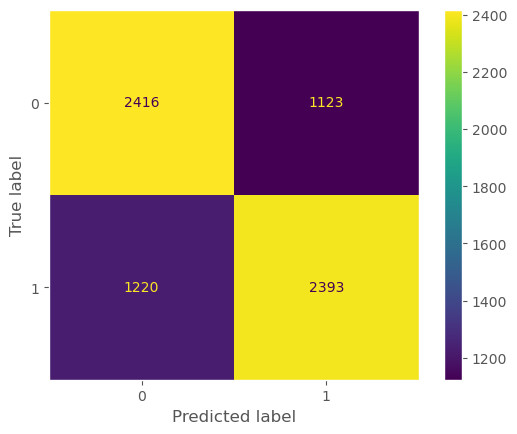

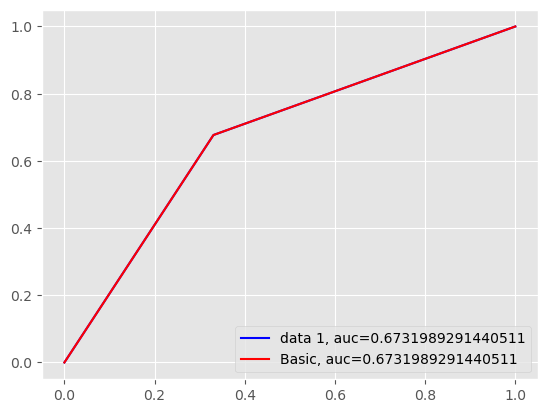

In [9]:
# Linear SVC with RFECV
model = svm.LinearSVC(C=6, loss='hinge')

cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1, random_state=14)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()

y_pred_proba = result.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc), color='blue')
plt.plot(fpr_basic, tpr_basic, label="Basic, auc="+str(auc), color='red')
plt.legend(loc=4)
plt.show()

# SVC plot


In [7]:
from sklearn import svm
import matplotlib.pyplot as plt
# import seaborn as sns

from mlxtend.plotting import plot_decision_regions

model = svm.LinearSVC(C=6, loss='hinge')

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


y_pred_proba = result.predict(X_test)


plot_decision_regions(X_train, y_train, clf=model, legend=2)
plt.show()

# plt.figure(figsize=(10, 8))
# # Plotting our two-features-space
# sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1],
#                 hue=y_train,
#                 s=8)
# # Constructing a hyperplane using a formula.
# w = model.coef_[0]           # w consists of 2 elements
# b = model.intercept_[0]      # b consists of 1 element
# x_points = np.linspace(-1, 1)    # generating x-points from -1 to 1
# y_points = -(w[0] / w[1]) * x_points - b / \
#     w[1]  # getting corresponding y-points
# # Plotting a red hyperplane
# plt.plot(x_points, y_points, c='r')

              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      3539
         1.0       0.67      0.67      0.67      3613

    accuracy                           0.67      7152
   macro avg       0.67      0.67      0.67      7152
weighted avg       0.67      0.67      0.67      7152



ValueError: X must be a NumPy array. Found <class 'pandas.core.frame.DataFrame'>

# [Legacy] Passive Aggressive Classifier


              precision    recall  f1-score   support

         0.0       0.68      0.65      0.67      3642
         1.0       0.67      0.71      0.69      3717

    accuracy                           0.68      7359
   macro avg       0.68      0.68      0.68      7359
weighted avg       0.68      0.68      0.68      7359



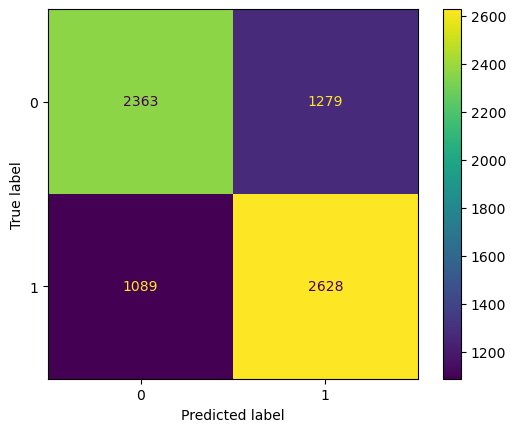

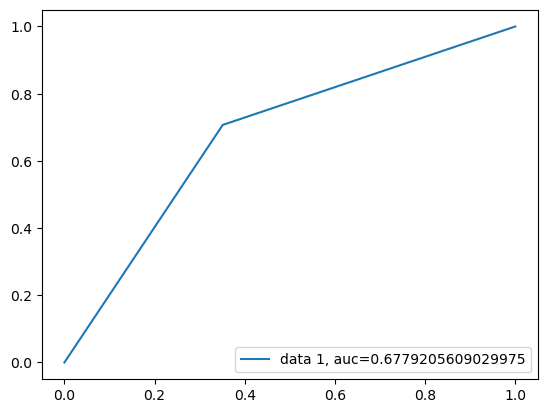

In [7]:
# Passive Aggressive Classifier Basic hiperparameters
from sklearn.linear_model import PassiveAggressiveClassifier


model = PassiveAggressiveClassifier(average=True, random_state=75)


result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()


y_pred_proba = result.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Best Score: 0.588797789799672
Best Hyperparameters: {'C': 33}
              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60      3642
         1.0       0.63      0.80      0.70      3717

    accuracy                           0.66      7359
   macro avg       0.67      0.66      0.65      7359
weighted avg       0.67      0.66      0.65      7359



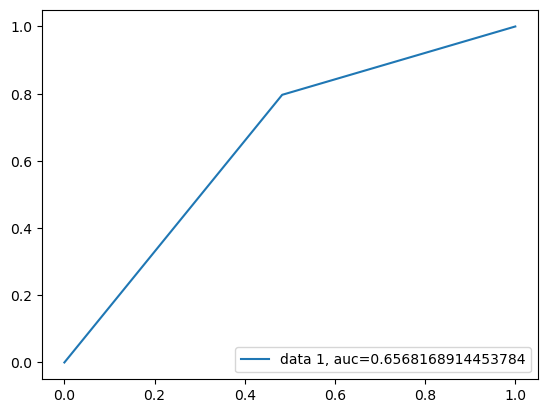

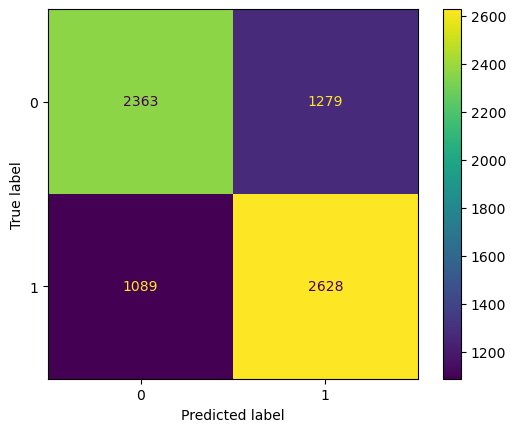

In [12]:
# Passive Aggressive Classifier with RandomizedSearchCV

model = PassiveAggressiveClassifier()

param_grid = {'C': range(1, 100, 1)
              }


search = RandomizedSearchCV(model, param_grid, n_iter=5,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


best_random = result.best_estimator_
y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

Optimal number of features : 13
                                  Rank
match_id                             1
total_serve_points_P1_diff           1
completeness_P1_diff                 1
serve_points_won_P1_diff             1
points_on_return_P1_diff             1
first_won_serve_P1_diff              1
surface_wins_P1_diff                 1
win_percentage_P1_diff               1
bp_factor_P1_diff                    1
age_P1_diff                          1
rank_points_P1_diff                  1
games_played_P1_diff                 1
first_serve_return_P1_diff           1
elo_P1_diff                          2
draw_size                            3
aceDf_P1_diff                        4
df_probability_P1_diff               5
second_won_serve_P1_diff             6
double_fault_probability_P1_diff     7
ht_P1_diff                           8
glicko_P1_diff                       9
ace_probability_P1_diff             10


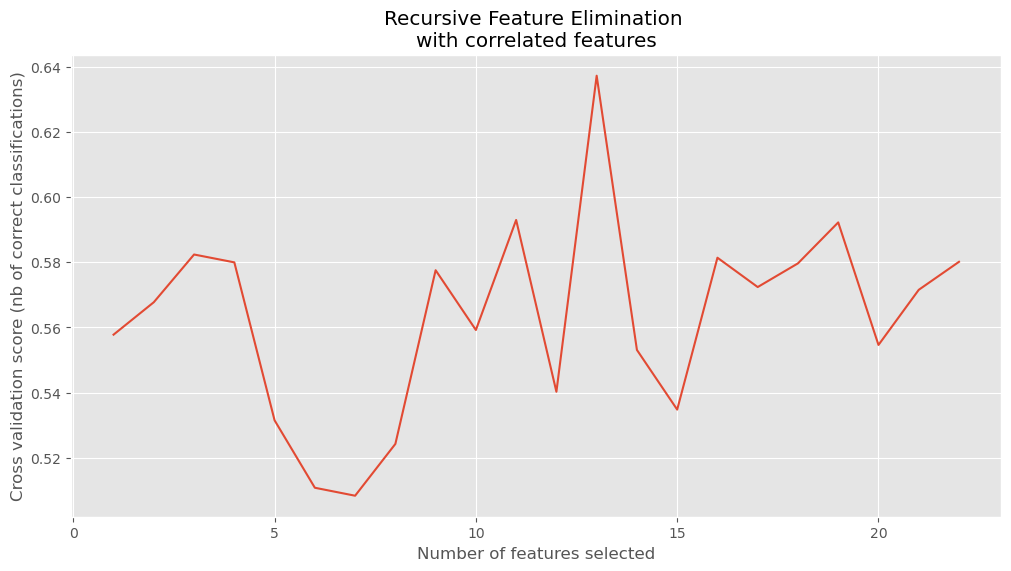

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66      3642
         1.0       1.00      0.00      0.01      3717

    accuracy                           0.50      7359
   macro avg       0.75      0.50      0.33      7359
weighted avg       0.75      0.50      0.33      7359



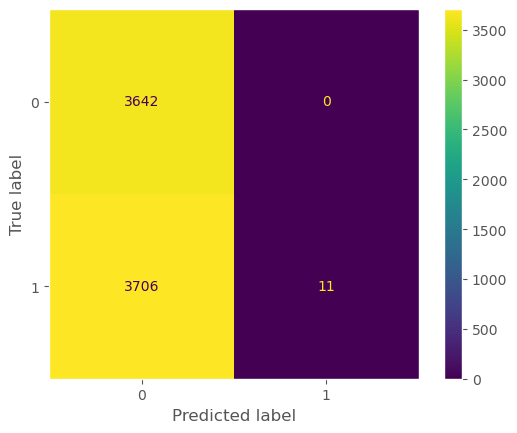

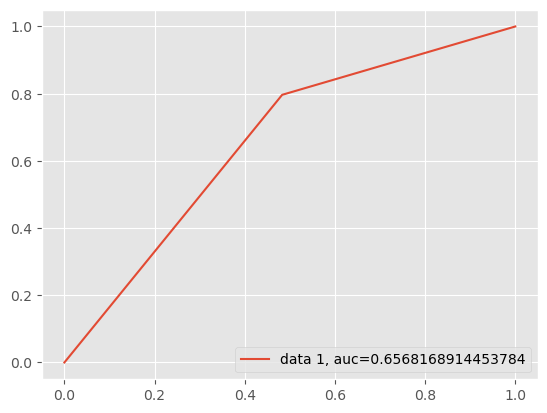

In [15]:
# Passive Aggressive Classifier with RFECV

model = PassiveAggressiveClassifier(C=result.best_params_['C'])

cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()

y_pred_proba = result.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()